# Denosing with Ising Model

NB :all the code are done from scratch. In fact, this experiment is inspired by a homework from the course "Propabilistic Graphical  Models" (MVA)

**0. Imports**

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import gamma
import matplotlib.pyplot as plt
import cv2
from scipy.stats import norm
from scipy.stats import multivariate_normal
from tqdm import tqdm


**1. Loopy Belief Propagation**

In [2]:
#Loopy Belief Propagation class
class LBP:

    def __init__(self, impath, iterations, params, add_noise = False):
        '''
        impath: Path to image, may be png or csv
        iterations: Number of iterations
        params: Theta and Gamma values
        add_noise: Whether to add external noise to input image. Useful for testing.
        '''
        self.impath = impath
        self.iterations = iterations
        self.params = params
        self.add_noise = add_noise
        
        #The model taken into account, as for the gaussian posteriori on the pixels, is encoded
        #in the two matrixes compataibility inter and compatibility outer
        
        #A posteriori likelihood depending on the pixel values
        self.compatibility_inter= np.array([[multivariate_normal.pdf(0,self.params['mu_0'],1), multivariate_normal.pdf(1,self.params['mu_0'],1)],
                                       [multivariate_normal.pdf(0,self.params['mu_1'],1), multivariate_normal.pdf(1,self.params['mu_1'],1)]])
        
        #Joint proba distribution between two adjacent pixels
        self.compatibility_outer= np.array([[np.exp(self.params['B']), np.exp(self.params['a'])],
                                       [np.exp(self.params['a']), np.exp(2*self.params['a']+self.params['B'])]])
        self.preprocess()

    # Function to preprocess image
    def preprocess(self):

        if self.impath[-3:] == 'png' or self.impath[-3:] == 'jpg':
            image = cv2.imread(self.impath, cv2.IMREAD_GRAYSCALE)/255
            image = cv2.threshold(image, 0.5, 1, cv2.THRESH_BINARY)[1]

        self.noiseless_image = image.copy()

        #Adding noise
        if self.add_noise:
            
            for j in range(image.shape[0]*image.shape[1]):
                idx = np.unravel_index(j, (image.shape[0], image.shape[1]))
                thresh = np.random.random_sample()
                if thresh < self.params['flip_prob']:
                    image[idx] = 1-image[idx]

        self.image = image
        self.height, self.width = self.image.shape


    # Function to perform synchronous message passing, as opposed with sequential which 
    # simply took to much memory for me to code. The creation of a matrix with enough elements to simulate 
    #the image as a fully connected graph is impossile on my computer's memory
    def messages_sync(self):

        clique_messages = np.ones((self.height, self.width, 2, 4))
        factor_messages = np.ones((self.height, self.width, 2, 4))
        factor_norm = np.ones((self.height, self.width, 1, 4))
        clique_norm = np.ones((self.height, self.width, 1, 4))
        beta = np.ones((self.height, self.width, 2))

        for j in range(self.height*self.width):
            beta[np.unravel_index(j, (self.height, self.width))] = self.compatibility_outer[:, int(self.image[np.unravel_index(j, 
                (self.height, self.width))])]

        for i in range(self.iterations):

            factor_messages[:,:,:,0] *= beta*clique_messages[:,:,:,0]*clique_messages[:,:,:,2]*clique_messages[:,:,:,3]
            factor_messages[:,:,:,1] *= beta*clique_messages[:,:,:,1]*clique_messages[:,:,:,2]*clique_messages[:,:,:,3]
            factor_messages[:,:,:,2] *= beta*clique_messages[:,:,:,2]*clique_messages[:,:,:,0]*clique_messages[:,:,:,1]
            factor_messages[:,:,:,3] *= beta*clique_messages[:,:,:,3]*clique_messages[:,:,:,0]*clique_messages[:,:,:,1]


            for j in range(clique_messages.shape[-1]):
                factor_norm[:,:,:,j] = np.sum(factor_messages[:,:,:,j], axis=2)[..., None]

            for j in range(clique_messages.shape[-1]):
                for ii in range(2):
                    factor_messages[:, :, ii, j] /= np.squeeze(factor_norm[:,:,:,j])

            clique_messages[:,:,:,0] *= self.compatibility_inter.dot(np.append(np.ones((self.height, 1, 2)), 
                                        factor_messages[:,:-1,:, 0], axis=1).transpose((0,2,1))).transpose(1,2,0)
            clique_messages[:,:,:,1] *= self.compatibility_inter.dot(np.append(factor_messages[:, 1:, :, 1], 
                                        np.ones((self.height, 1, 2)), axis = 1).transpose((0,2,1))).transpose(1,2,0)
            clique_messages[:,:,:,2] *= self.compatibility_inter.dot(np.append(factor_messages[1:,:, :, 2], 
                                        np.ones((1, self.width, 2)), axis = 0).transpose((0,2,1))).transpose(1,2,0)
            clique_messages[:,:,:,3] *= self.compatibility_inter.dot(np.append(np.ones((1, self.width, 2)), 	
                                        factor_messages[:-1,:, :, 3], axis = 0).transpose((0,2,1))).transpose(1,2,0)

            for j in range(clique_messages.shape[-1]):
                clique_norm[:,:,:,j] = np.sum(clique_messages[:,:,:,j], axis=2)[..., None]

            for j in range(clique_messages.shape[-1]):
                for ii in range(2):
                    clique_messages[:, :, ii, j] /= np.squeeze(clique_norm[:,:,:,j])

        for j in range(clique_messages.shape[-1]):
            beta *= np.append(np.ones((self.height, 1, 2)), factor_messages[:,:-1,:,0], axis=1)\
                    *np.append(np.ones((1, self.width, 2)), factor_messages[:-1,:,:,3], axis = 0)\
                    *np.append(factor_messages[1:,:,:,2], np.ones((1, self.width, 2)), axis = 0)\
                    *np.append(factor_messages[:, 1:,:,1], np.ones((self.height, 1, 2)), axis = 1)

        if self.add_noise:
            accuracy = np.sum(self.noiseless_image == np.argmax(beta, axis = 2)) #/(self.height*self.width)
            return(self.image, np.argmax(beta, axis = 2), self.noiseless_image, accuracy)
        else:
            return(self.image, np.argmax(beta, axis = 2))

mode = "sync"
add_noise = "True"




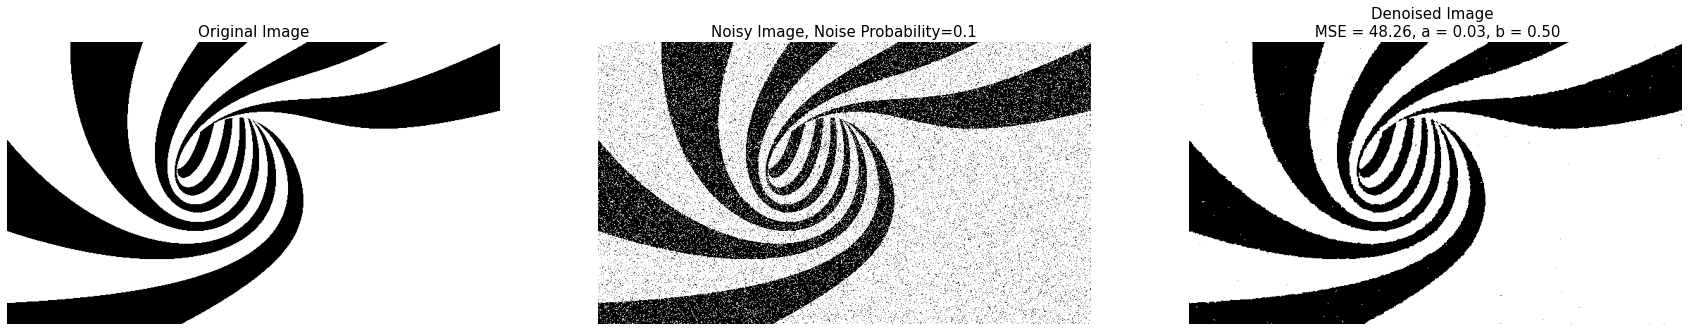

In [4]:
image_path = 'spiral.png'
params = {'a':0.03, 'B':0.5, 'mu_0':0, 'mu_1':1,'flip_prob': 0.1}
L = LBP(image_path, 3, params, add_noise)


image, denoised, noiseless, _ = L.messages_sync()
plt.figure(figsize=(30, 50))
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Original Image',fontsize=15)	
plt.imshow(noiseless, cmap = 'Greys_r')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Noisy Image, Noise Probability={}'.format(0.1),fontsize=15)
plt.imshow(image, cmap = 'Greys_r')
plt.subplot(1,3,3)
plt.axis('off')
accuracy = np.linalg.norm(denoised- noiseless)
plt.title('Denoised Image \n MSE = {0:.2f}, a = {1:.2f}, b = {2:.2f}'.format(accuracy, 
     params['a'], params['B']),fontsize=15)
plt.imshow(denoised, cmap = 'Greys_r')
plt.show()

**2. Gibbs**

$$p(x_k|x_{\neg k},y) = \frac{p(x_k|y)}{p(x_{\neg k}|y)}  \propto \ 
\phi_k \left( x_k \right) \prod_{l \in \mathcal{N}(k)} \mu_{l \rightarrow k} \left( x_k\right) \mathcal{N}(\mu_{x_k},1) f(x_{\neg k}) $$

In [5]:
def pi(z,a,B,mu,image,i,j):
    p_exact = np.zeros((2))    
    H,W = image.shape
    for k in range(2):
        neighbors = z[max(i-1,0):min(i+2,H), max(j-1,0):min(j+2,W)].flatten()
        p_exact[k] = norm.pdf(image[i,j],mu[k],1)*np.exp(a*k + B*np.sum(neighbors == k))
    p_exact = p_exact/np.sum(p_exact)
   
    return p_exact

In [9]:
def Gibbs(iterations,z0,a,B,mu,image):
    z = z0
    H,W = z0.shape
    for step in tqdm(range(iterations)):
      for i in range(H):
        for j in range(W):
          p_exact = pi(z,a,B,mu,image,i,j)
          realisation = np.where(np.random.multinomial(1,p_exact)==1)[0][0]
          z[i,j] = realisation
    return z

In [12]:
a = 0.03
B = 0.6
mu = [0,1]
iterations = 20
noisy_image = image.astype('int')
x0 = np.random.random(noisy_image.shape)>0.5

In [13]:
denoised = Gibbs(iterations,x0,a,B,mu,noisy_image)

100%|██████████| 20/20 [22:50<00:00, 68.54s/it]



Text(0.5, 1.0, 'Denoised by Gibbs Sampling : MSE')

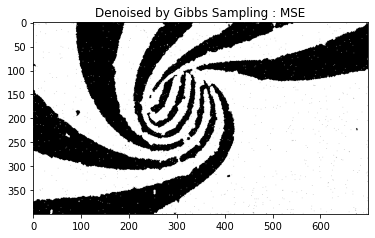

In [21]:
plt.imshow(denoised,cmap='Greys_r')
plt.title("Denoised by Gibbs Sampling : MSE")

**3.Stochastic EM**
> Learn $\mu_0$ and $\mu_1$ while denoising

Let $y = (y_1,... , y_n)$  a sample of $n$ independent observations from a mixture of $2$ multivariate normal distributions, and  $x = (x_1, ... , x_n)$ are the
latent variables that determine the component from which the observation originates.

We assume that $$ y_i| (x_i = k ) ∼ \mathcal {N}(\mu_k, 1)$$
where $P(x_i = 1) = p_i = \frac{1}{Z_{\alpha, \beta}} \phi_i (1) \prod_{l \in \mathcal{N}(i)} \mu_{l \rightarrow i}( 1 )$. Our aim is to estimate the unknown parameters $\theta =(\mu_0,\mu_1) $ where the incomplete-data likelihood function is
$$L(θ; y) = \prod_{i=1}^n \left(p_i \mathcal{N}(y_i; \mu_1, 1)+(1-p_i) \mathcal{N}(x_i; \mu_0, 1)\right)$$
and the complete-data log-likelihood function is
$$\log(L(θ; y, x))= \sum_{i=1}^n (\log(p_i)+ \log(1-p_i)− \frac{1}{2} (y_i− \mu_0)^2 -\frac{1}{2} (y_i− \mu_0)^2 ) − n \log(2\pi) $$

* E-step: 

Given a previous estimate of the parameters $\theta^{(t)}$, the
conditional distribution of the $x_i$ is determined by Bayes theorem to be :
$$\gamma_{i1}^{(t)} = \frac{p_i \mathcal{N}(y_i; \mu_1^{(t)}, 1)}{p_i \mathcal{N}(y_i; \mu_1^{(t)}, 1)+ (1-p_i) \mathcal{N}(y_i; \mu_0^{(t)}, 1)}$$
$$\gamma_{i0}^{(t)} = \frac{(1-p_i) \mathcal{N}(y_i; \mu_0^{(t)}, 1)}{p_i \mathcal{N}(y_i; \mu_1^{(t)}, 1)+ (1-p_i) \mathcal{N}(y_i; \mu_0^{(t)}, 1)}$$
This E step corresponds to the function $Q$ defined by:
$$\begin{split} Q(\theta|\theta^{(t)}) &= \mathbb{E}_{x|y,\theta^{(t)}}[\log L(\theta; y, x)] \\
&=\sum_{i=1}^n  \gamma_{i0}^{(t)}(\log(1-p_i)− \frac{1}{2} (y_i− \mu_0)^2)+\gamma_{i1}^{(t)}(\log(p_i)− \frac{1}{2} (y_i− \mu_1)^2) -n \log(2\pi) \end{split}$$
* M step :

The second step maximizes $ Q(\theta|\theta^{(t)})$ with respect to $\theta$. 
 $$\boxed{\mu_k =\frac{\sum_{i=1}^n \gamma_{ik}^{(t)} y_i}{\sum_{i=1}^n \gamma_{ik}^{(t)}} \mbox{   for } k \in \{0,1\} }$$

We can combine the MCMC with the EM to simulate the $p_i$. Actually, we are applying a simulated EM.

In [22]:
def SEM(iterations_EM,iterations_Gibbs,x0,a,B,mu_0,noisy_image):
  x = x0
  mu = mu_0
  likelihood = []
  for iteration in tqdm(range(iterations_EM)):
    x = Gibbs(iterations_Gibbs,x,a,B,mu,noisy_image)
    mu_0 = np.sum(noisy_image[x==0])/np.sum(x==0)
    mu_1 = np.sum(noisy_image[x==1])/np.sum(x==1)
    mu = [mu_0, mu_1]
    
  return mu,x


In [23]:
mu, x = SEM(5,5,x0,a,B,mu0,noisy_image)

100%|██████████| 5/5 [28:51<00:00, 346.27s/it]


In [25]:
plt.imshow(x, cmap='Greys_r'), mu
plt.title("Denoised with SEM )

SyntaxError: ignored